### Created on Thu Mar 22 17:18:52 2018

### @author: nanthony

In [15]:
import random
import numpy as np 
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib notebook
pinv = np.linalg.pinv

In [16]:
yaw = np.matrix([[0,0,1,0]])
pitch = np.matrix([[0,1,0,0]])
roll = np.matrix([[1,0,0,0]])
thrust = np.matrix([[0,0,0,1]])
rand = np.matrix([[random.uniform(-1,1) for i in range(4)]]) #r,p,y,t
sat = np.matrix([[1,1,1,1]])

In [17]:
g = np.zeros((1,4)) #contains the actuator outputs

B = np.matrix([ #The transfer matrix giving scalers for how much each command input should affect each rotor
                        [ -0.707107,  0.707107,  1.000000,  1.000000 ], #Columns are roll, pitch, yaw, thrust
                        [ 0.707107, -0.707107,  1.000000,  1.000000 ], #Rows are each of the 4 rotors
                        [ 0.707107,  0.707107, -1.000000,  1.000000 ], #this example was copies from the quad_x config in "mixer_multirotor_normalized.generated.h"
                        [ -0.707107, -0.707107, -1.000000,  1.000000 ],
                    ])

In [18]:
for x in [yaw,pitch,roll,thrust,rand,sat]:
    #out = np.linalg.multi_dot([mixerSens,command.transpose()])
    u = B * x.transpose()
    print("Command:\n", x,'\n')
    print(u,'\n')

Command:
 [[0 0 1 0]] 

[[ 1.]
 [ 1.]
 [-1.]
 [-1.]] 

Command:
 [[0 1 0 0]] 

[[ 0.707107]
 [-0.707107]
 [ 0.707107]
 [-0.707107]] 

Command:
 [[1 0 0 0]] 

[[-0.707107]
 [ 0.707107]
 [ 0.707107]
 [-0.707107]] 

Command:
 [[0 0 0 1]] 

[[1.]
 [1.]
 [1.]
 [1.]] 

Command:
 [[ 0.0317835   0.64569243 -0.73838781  0.20521135]] 

[[-0.09907716]
 [-0.96727577]
 [ 1.42264713]
 [ 0.46455119]] 

Command:
 [[1 1 1 1]] 

[[ 2.      ]
 [ 2.      ]
 [ 1.414214]
 [-1.414214]] 



## Control Scheme

In the simplest case we can determine out actuator outputs, $\vec{g}$ in the following manner:

eqn 1: $B \vec{x} = \vec{g}$

Where $\vec{x}$ is the vector of our commanded torques and thrusts. $\vec{x} = \begin{bmatrix} \vec{m} \\ \vec{t}\end{bmatrix}$ and $B$ is the vehicle dependent matrix that maps our commands to our actuator outputs.

Since in practice the values of $\vec{g}$ are limited to a certain range it may be necessary to scale our input values to avoid saturation. We will call $\vec{u}$ after it has been cropped such that none of its values lie outside the allowable range $\vec{G}$. We do this using the matrix $S$.

eqn 2: $\vec{G} = B (\vec{x} + \vec{a})$

Where $\vec{a}$ is a vector that adjusts each of the inputs from $\vec{x}$

Under ideal conditions $\vec{a}$ should be $0$ but when the actuator outputs are saturated then the $\vec{a}$ should take on a value such that none of the outputs are saturated.

Our goal is to find $\vec{a}$ such that $U$ lies within the available space $-1 \leq G_i \leq 1$.

There are many possible solutions. We should try to find the solution that has the least impact on the original command, $\vec{x}$. In other words we want to minimize $\bigl|\vec{a}\bigr|$. However in order to use interior point method we need our optimization function to be twice differentiable so let's minimize $\sum \vec{a}^2$

We can also express the problem as $\vec{G} = B\vec{X}$ where $\vec{X} = \vec{x} + \vec{a}$/ In this case we want to minimize $\sum (\vec{X} - \vec{x})^2$

In [19]:
x = roll
g = B * x.transpose()
print(g,'\n')
print(B*pinv(B)*g)

[[-0.707107]
 [ 0.707107]
 [ 0.707107]
 [-0.707107]] 

[[-0.707107]
 [ 0.707107]
 [ 0.707107]
 [-0.707107]]


So there is a solution.

The solution is unique only if $[I - B^+B]$ is the zero matrix.

In [20]:
np.eye(4) - pinv(B)*B

matrix([[ 0.00000000e+00,  1.63873307e-18,  0.00000000e+00,
          0.00000000e+00],
        [ 5.23878047e-17,  1.11022302e-16, -5.55111512e-17,
         -1.11022302e-16],
        [ 5.55111512e-17, -1.02892889e-16,  1.11022302e-16,
         -1.11022302e-16],
        [ 3.92523236e-17,  0.00000000e+00,  1.66533454e-16,
          0.00000000e+00]])

Close enough. the solution is unique. However there are many ways that $\vec{u}$ can be adjusted so that it satisfies the constraint $-1 \leq U_i \leq 1$.

On stack exchange they reccomended minimizing $\bigl|\vec{a}^2\bigr|$ using interior point quadratic programming. https://math.stackexchange.com/questions/2708993/finding-minimum-vector-to-satisfy-constraints-in-linear-system/2709062#2709062

In [21]:
import pyipopt

In [22]:
'''
For the following functions and values we must be careful to return a 1d array.
A 2d array will result in strange errors due to poor handling of the
python/C interface in pyipopt. We also make sure that we return floats
instead of ints for the same reason.
'''
x=rand
H = np.diag([5,5,.1,1])
x = np.array(x).astype(np.float).squeeze()
nvar = 4 #we have four variables (roll,pitch,yaw,thrust)
x_L = np.array([-1,-1,-1,-1],dtype=np.float) #The variables may not drop below -1. For some reason ipopt doesn't recognize these if they are one.
x_U = np.array([1,1,1,1],dtype=np.float) #$The variables may not go above 1
ncon = 4 #We have 4 constraints (the actuator outputs)
g_L = np.array([-1,-1,-1,-1],dtype=np.float) #the actuator outputs must lie between -1 and 1
g_U = np.array([1,1,1,1],dtype=np.float)


def eval_f(X):
    '''
    we want to minimize the sum of squares of the original command
    vector minus the calculated command vector. The sum is weighted by H
    so that we can put more stringent constraints on some axes than on others.
    '''
    xx = np.matrix(x - X)
    res = xx * H * xx.transpose()
    res = np.array(res,dtype=np.float).squeeze()
    return res

def eval_grad_f(X):
    '''This gives the gradient of the objective function'''
    res = 2 * H * np.matrix(X - x).transpose()
    res = np.array(res,dtype=np.float).squeeze()
    return res

def eval_g(X):
    '''return the constrained values (the actuator outputs)'''
    res = np.array(B * np.matrix(X).transpose(),dtype=np.float).squeeze()
    return res

## To help us figure out the jacobian let's write eval_g out in long form

$\vec{U} = \begin{bmatrix} B_{1,1}X_1 + B_{1,2}X_2 + B_{1,3}X_3 + B_{1,4}X_4\\ B_{2,1}X_1 + B_{2,2}X_2 + B_{2,3}X_3 + B_{2,4}X_4\\B_{3,1}X_1 + B_{3,2}X_2 + B_{3,3}X_3 + B_{3,4}X_4\\B_{4,1}X_1 + B_{4,2}X_2 + B_{4,3}X_3 + B_{4,4}X_4 \end{bmatrix}$


In [23]:
def eval_jac_g(x,flag):
    #if flag is true then return a tuple of 2 arrays (rows,columns) giving the structure of the jacobian 
    #if flag is true return a 1d array of the values of the jacobian.
    
    #In this case the jacobian is just the B matrix
    if flag:
        return (np.array([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]),
                np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]))
    else:
        assert len(x)==4
        return np.array([
            B[0,0],
            B[0,1],
            B[0,2],
            B[0,3],
            B[1,0],
            B[1,1],
            B[1,2],
            B[1,3],
            B[2,0],
            B[2,1],
            B[2,2],
            B[2,3],
            B[3,0],
            B[3,1],
            B[3,2],
            B[3,3],
        ], dtype=np.float)
    
nnzj = 16 #This is the number of non-zero elements of the jacobian. In most cases none of them are zero.

from https://list.coin-or.org/pipermail/ipopt/2013-February/003241.html

'''
Given a QP of the form $\min{x} -> \frac{x’Hx}{2} + f’x$

With the constraints:  
$rl <= A*x<= ru$  
and  
$lb <= x<= ub$  

Then the Hessian is:  
$Hess = \frac{H + H’}{2}$


 And objective gradient is:

 $Grad = \frac{H + H’}{2} x + f$



 And the Jacobian is simply the $A$ matrix from your linear constraints. Note
 for linear constraints the Hessian of the Lagrangian only contains
 quadratic terms from the objective (as Hess above), and no constraints
 feature (given they are all linear). See Ogata Discrete Time Control
 Systems for more details on the above.
'''

In [24]:
def eval_h(x, lagrange, obj_factor, flag,user_data=None):
    if flag:
        return (np.array([0,1,2,3]),np.array([0,1,2,3]))
    else:
        res = np.array([
                2*H[0,0],
                2*H[1,1],
                2*H[2,2],
                2*H[3,3]
                ],dtype=np.float)
        return res

nnzh = 4 #This is the number of non-zero elements of the hessian. In this case it is only the diagonals.

In [25]:
nlp = pyipopt.create(nvar,x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g, eval_h)

[PyIPOPT] Problem created


In [26]:
newx, zl, zu, constraint_multipliers, obj, status = nlp.solve(x)
nlp.close()

[Logspam] built arglist for eval_h
[Logspam] Python function eval_h returns non-NULL


True

In [27]:
print("Solution of the primal variables, x")
print(newx)

print("Solution of the bound multipliers, z_L and z_U")
print(zl)
print(zu)

print("Solution of the constraint multipliers, lambda")
print(constraint_multipliers)

print("Objective value")
print("f(x*) = {}".format(obj))

Solution of the primal variables, x
[ 0.02644677  0.6403557  -0.36102428  0.167475  ]
Solution of the bound multipliers, z_L and z_U
[2.44269374e-09 1.52717776e-09 4.27622350e-09 2.15183466e-09]
[2.57246901e-09 6.97795757e-09 1.80013688e-09 2.99918462e-09]
Solution of the constraint multipliers, lambda
[ 1.07646788e-09 -6.59474116e-09  7.54726978e-02  4.78776590e-10]
Objective value
f(x*) = 0.01594916195969545


<IPython.core.display.Javascript object>


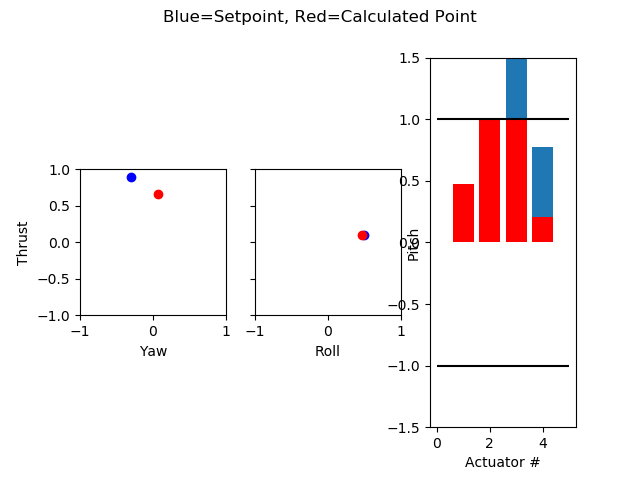

interactive(children=(FloatSlider(value=0.031783496434900194, description='roll', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.6456924289072208, description='pitch', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.205211349369661, description='thrust', max=1.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=-0.7383878121064054, description='yaw', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

In [28]:
class plotter:
    def __init__(self,outputs=True):
        self.outputs = outputs
        self.fig = plt.figure()
        if self.outputs:
            totalCols = 3
        else:
            totalCols = 2
        self.axl = self.fig.add_subplot(1,totalCols,1)
        self.axr = self.fig.add_subplot(1,totalCols,2)
        self.axr.yaxis.set_ticklabels([])
        self.axr.set_xlim((-1,1))
        self.axl.set_xlim((-1,1))
        self.axr.set_ylim((-1,1))
        self.axl.set_ylim((-1,1))
        self.axr.yaxis.set_label_position('right')
        self.axl.set_xlabel("Yaw")
        self.axl.set_ylabel("Thrust")
        self.axr.set_xlabel("Roll")
        self.axr.set_ylabel("Pitch")
        self.axr.set_aspect('equal')
        self. axl.set_aspect('equal')
        self.fig.suptitle("Blue=Setpoint, Red=Calculated Point")
        self.origScatL = self.axl.scatter(x[2],x[3],color='b')
        self.newScatL = self.axl.scatter(newx[2],newx[3],color='r')
        self.origScatR = self.axr.scatter(x[0],x[1],color='b')
        self.newScatR = self.axr.scatter(newx[0],newx[1],color='r')
        if self.outputs:
            self.ax3 = self.fig.add_subplot(1,totalCols,3)
            self.origBarPlot = self.ax3.bar([1,2,3,4],eval_g(x))
            self.newBarPlot = self.ax3.bar([1,2,3,4],eval_g(newx),color='r')
            self.ax3.set_ylim((-1.5,1.5))
            self.ax3.hlines([-1,1],xmin=0,xmax=5)
            self.ax3.set_xlabel("Actuator #")
    def plot(self,origX,newX):
        self.origScatL.set_offsets(origX[2:])
        self.newScatL.set_offsets(newX[2:])
        self.origScatR.set_offsets(origX[:2])
        self.newScatR.set_offsets(newX[:2])
        if self.outputs:
            for i,v in enumerate(eval_g(origX)):
                self.origBarPlot[i].set_height(v)
            for i,v in enumerate(eval_g(newX)):
                self.newBarPlot[i].set_height(v)
        

pl=plotter()
        
@interact(roll=(-1,1,0.1))
def r(roll=x[0]):
    x[0] = roll
    nlp = pyipopt.create(nvar,x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g, eval_h)
    newx = nlp.solve(x)[0]
    pl.plot(x,newx)
@interact(pitch=(-1,1,0.1))
def p(pitch=x[1]):
    x[1] = pitch
    nlp = pyipopt.create(nvar,x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g, eval_h)
    newx = nlp.solve(x)[0]
    pl.plot(x,newx)
@interact(thrust=(0,1,0.1))
def t(thrust=x[3]):
    x[3] = thrust
    nlp = pyipopt.create(nvar,x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g, eval_h)
    newx = nlp.solve(x)[0]
    pl.plot(x,newx)
@interact(yaw=(-1,1,0.1))
def y(yaw=x[2]):
    x[2] = yaw
    nlp = pyipopt.create(nvar,x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g, eval_h)
    newx = nlp.solve(x)[0]
    pl.plot(x,newx)
